# **DATA CLEANING**

## Objectives

* Evaluate Missing data
* Cleaning data

## Inputs

* outputs/datasets/collection/house_price_records.csv

## Outputs

* outputs/datasets/collection/cleaned_house_price_records.csv

## Additional Comments

* ```EnclosedPorch``` and ```WoodDeckSF``` columns have about 90% data missing. Consider to drop them for analysis.

* Imputate missing data

* Create data cleaning pipeline


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [19]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/pp5_project_heritage_housing'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [20]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [21]:
current_dir = os.getcwd()
current_dir

'/workspace'

Load necessary modules

In [22]:
# plotting lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# for data cleaning
from sklearn.pipeline import Pipeline

---

# Data Cleaning

## Drop features with lot of missing data

As discussed in Sale Price Study notebook, we will drop two columns  ```EnclosedPorch``` and ```WoodDeckSF``` columns have about 90% data missing.

In [23]:
# Make sure to work on a copy of data
df_source_data=pd.read_csv("outputs/datasets/collection/house_price_records.csv")
df=df_source_data.copy()
df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/datasets/collection/house_price_records.csv'

**Split Train and Test Set**

In [47]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [28]:
# Drop two variables
variables_method = ['EnclosedPorch','WoodDeckSF']

from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

We don't need to evaluate distribution effect on dropped features as it is columns we are dropping, not rows. So, let's move forward

---

## Imputation for other missing data

We have concluded the following so far from previous workbook:


- ```LotFrontage```has 17.7 % missing values. However, ydata detailed profile report shows that it is  correlated with ```LotArea```, It also makes sense in physical world. Bigger the lot area, the higher the chances that LotFrontage (i.e. linear feet of street connected to property) is bigger. So, we can leverage this relation for missing data imputaion.

- ```GarageFinish```has 11.1% missing values. However, ydata detailed profile report shows that it is  correlated with  ```GarageArea```. In phsyical world, they are independent. For example, a bigger garden does not nessarily mean high qality finish. So, we may have to look at other areas to find imputation strategies, for ex. distribution.

- ```BsmtFinType1```has 7.8% missing values. However, ydata detailed profile report shows that it is  correlated with  ```BsmtExposure```. In physical world, "walkout or garden level walls exposure level" and "quality of basement" are independent. So, perhaps this correlation is just coinsidence. So, we may have to look at other strategies for data impuration, for ex. distribution.

- ```BedroomAbvGr```has 6.8% missing values. However, It seems to be highly correlated with ```2ndFlrSF```and ```GrLivArea```. In physical world it does not make sense. Bedroom above ground has no relation with 2nd floor surface area and living area. So, we may have to look at other strategies for data impuration, for ex. distribution.


- ```2ndFlrSF``` has 5.89% missing values. However, ydata detailed profile report shows that it is correlated with ```BedroomAbvGr```. As mentioned in previous bullet point, this does not make sense in physical world. So, we may have to look at other strategies for data impuration, for ex. distribtion.

- ```GarageYrBlt```has 5.5% missing values. However, ydata detailed profile report shows that it is  correlated with  ```GarageArea``` , ```SalePrice```and ```YearRemodAdd```. In physical world, it may be possible that with time (GarageYrBlt), larger and larger (or smaller and smaller) garages were built. It is possible that with newer the garage, better the sales price. We can explore these relationships further for missing data imputation. 


Now,
- As you can see there are two vaiables [LotFrontage,GarageYrBlt] where we can leverage regression to explore relationship with other variables and use that to fill missing data. That is multi variate data imputation.

- Feaure-engine currently supports univariate imputation stategies (Source: https://feature-engine.trainindata.com/en/latest/api_doc/imputation/index.html). For multi-variate imputation stategies, we need to use iterative imputer from Scikit-learn.

- This will broaden the scope of project, hence for now I decide to use univariate imputation strategies for all the variables listed above.

---

### Univariate Imputation using Feature Engine

- For ```GarageFinish``` and ```BsmtFinType1```, we will use categorical imputation

- For ```LotFrontage``` and ```BedroomAbvGr```, we will use mean impuration because the data is normally distributed with low skewness and kurtosis.

- For ```2ndFlrSF```, ```GarageYrBlt``` and ```MasVnrArea```, we will use median imputation the data is skewed with presense of outliers

Note : this is just a starting point, and we will analyse and change imputation method if necessary to preserve the original distribution as close as possible.

**Since we are modifiying rows, we need to create a custom function that will help evaluate the data cleaning effect on distribution of these variables pre cleaning and post cleaning. Theoretically speaking, they should be near similar.**

In [ ]:
# Adopted from Unit 9 of feature engine section

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):
  """
  Function to visualize data cleaning effect
  """
  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

**Categorical Imputation**


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1'] 




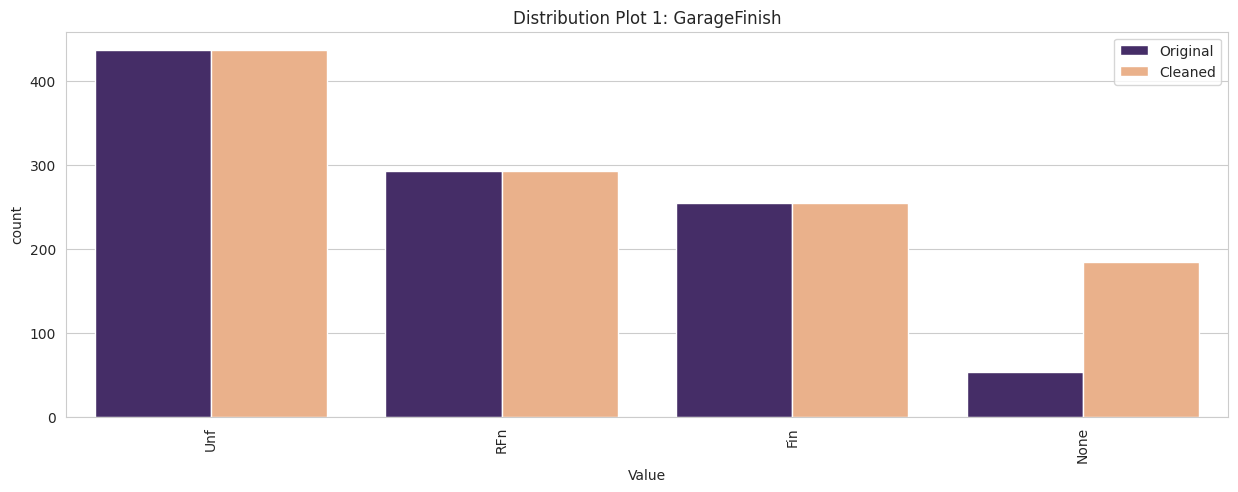

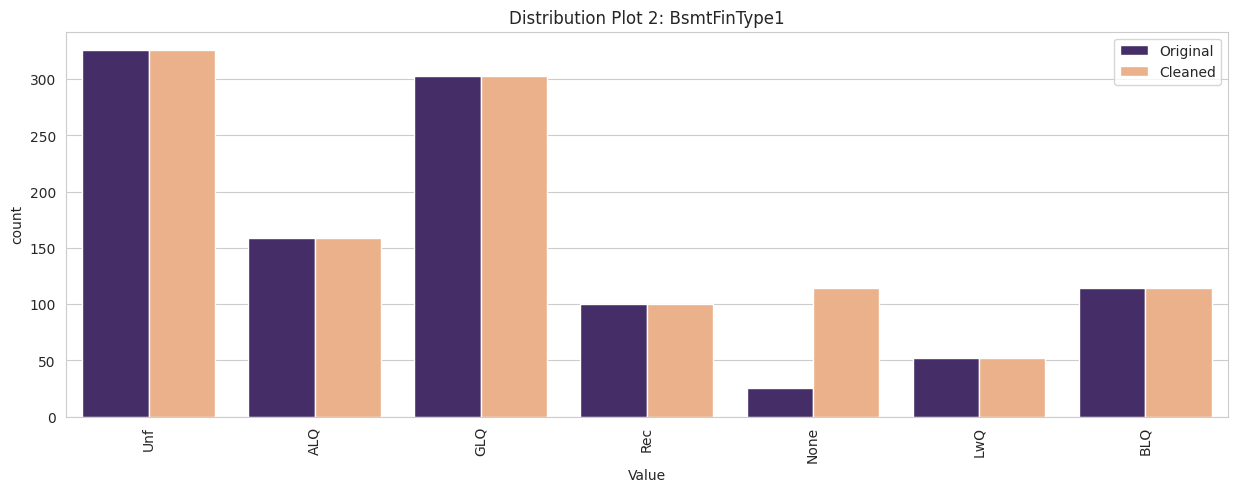

In [ ]:
from feature_engine.imputation import CategoricalImputer

var = ['GarageFinish' , 'BsmtFinType1']
imputer = CategoricalImputer(imputation_method='missing', fill_value='None', variables=var)
df_method = imputer.fit_transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=var)

The below data shows where GarageYrBlt is NaN, GarageArea is zero. So, it make sense to use categorical imputation with "None" as filler. 

In [31]:
TrainSet[(TrainSet['GarageArea'] ==0)][['GarageYrBlt', 'GarageArea']]

,GarageYrBlt,GarageArea
431,NaN,0
638,NaN,0
1337,NaN,0
528,NaN,0
960,NaN,0
1011,NaN,0
1283,NaN,0
1038,NaN,0
165,NaN,0
1349,NaN,0


For BsmtFinType1 , the distribution looks bimodal. So, we can try random sample imputation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['BsmtFinType1'] 




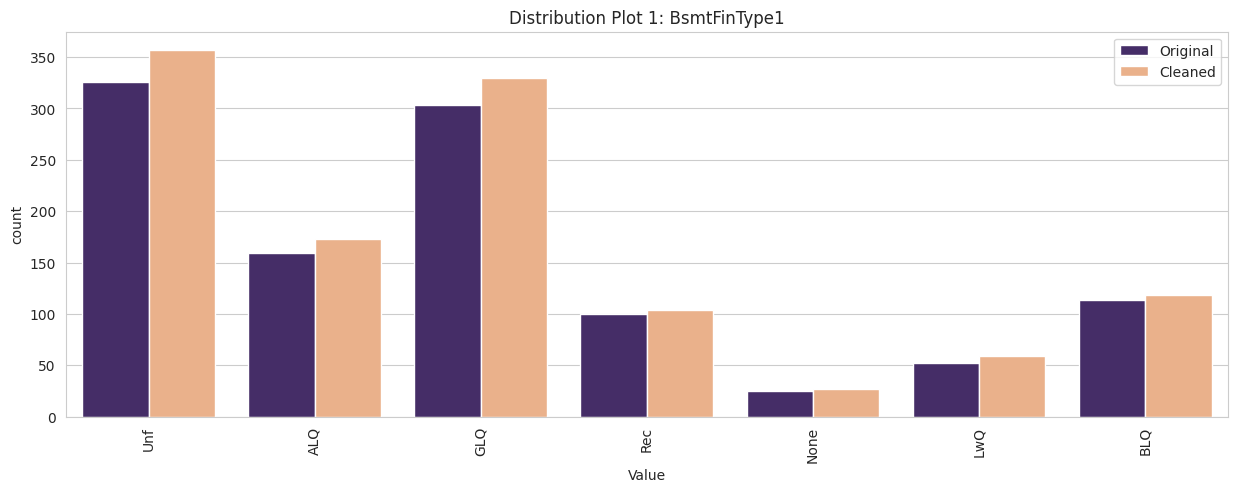

In [33]:
from feature_engine.imputation import RandomSampleImputer

var = ['BsmtFinType1']
imputer = RandomSampleImputer(variables=var)
df_method = imputer.fit_transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=var)

This distribution looks closer to original distribution, hence we will consider this as final imputation.

A down side of random sample distribution is that it distorts the relationship with other variables. 

It is important to keep in mind that, BasmFinType1 which refers to quality of basement, is related to overall quality and in general we have seen that with higher quality, sales prices increase. So, if introducting random samples affects that relation negatively, we can have a second look at imputation strategy.

**Median Imputation**


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'] 




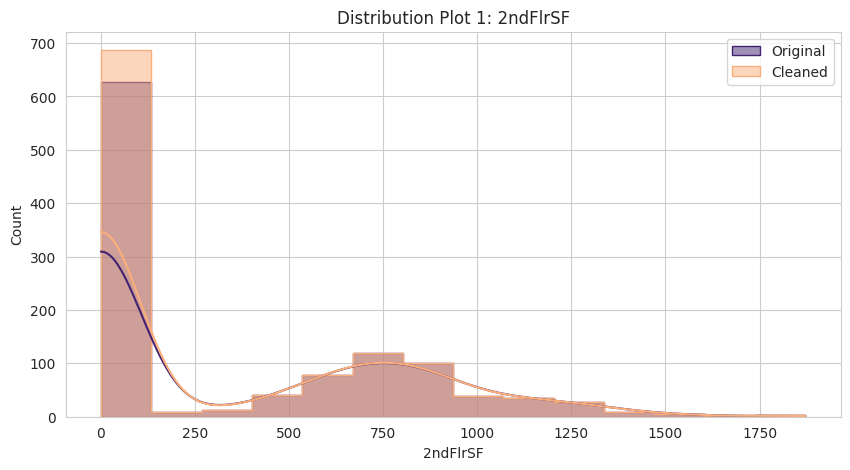

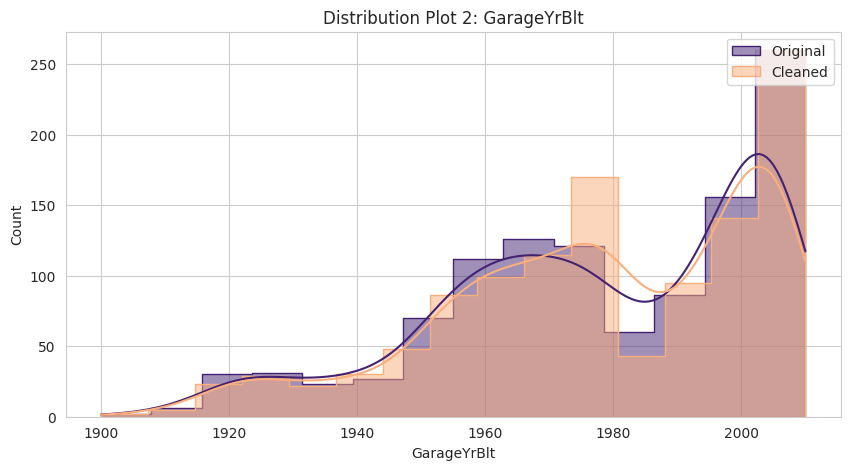

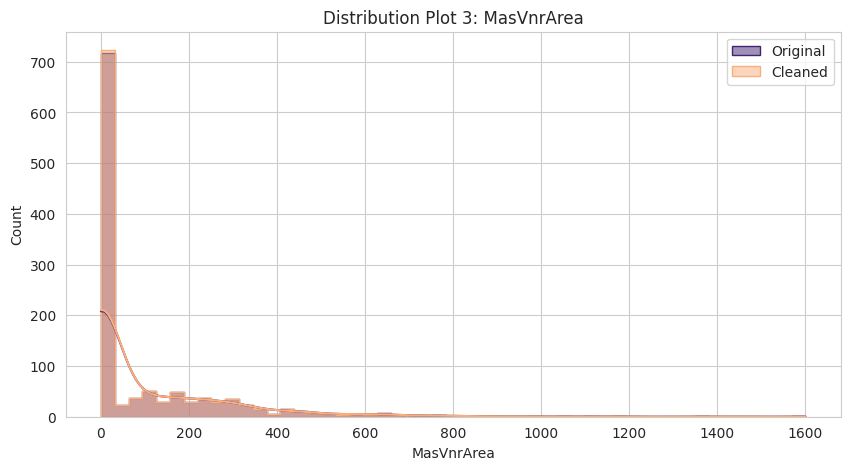

In [29]:
from feature_engine.imputation import MeanMedianImputer

var = ['2ndFlrSF' , 'GarageYrBlt', 'MasVnrArea']
imputer = MeanMedianImputer(imputation_method='median', variables=var)
df_method = imputer.fit_transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=var)

**Random Sample Imputaion**

Let's try random sample distribution for all three


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'] 




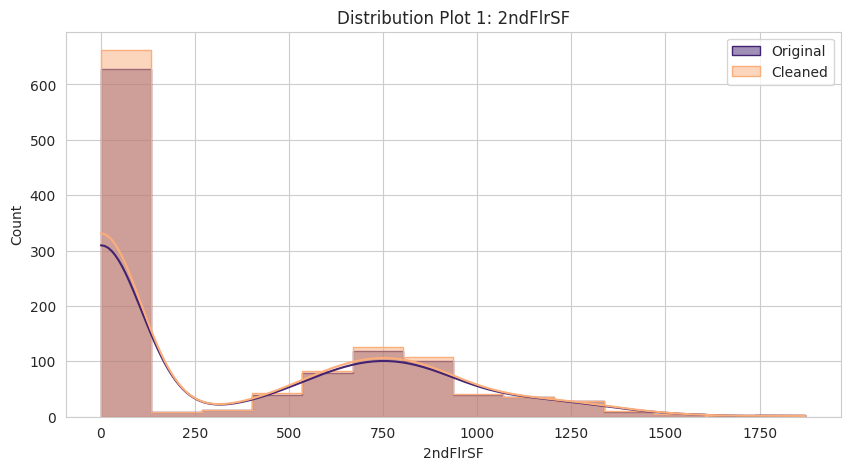

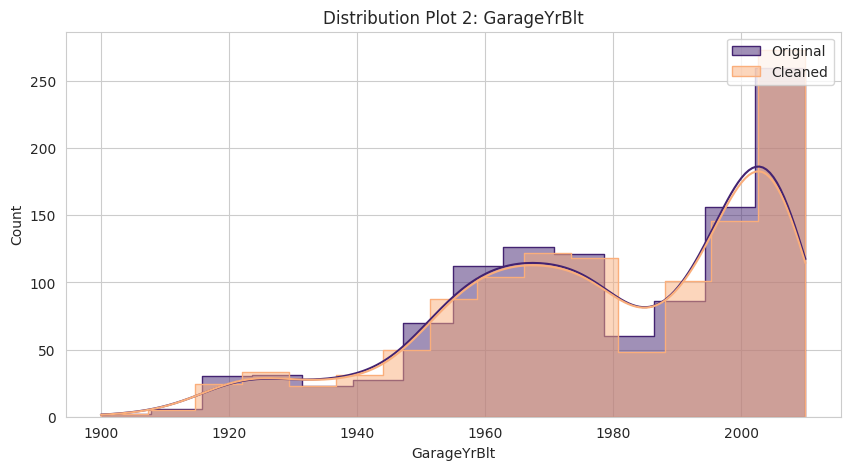

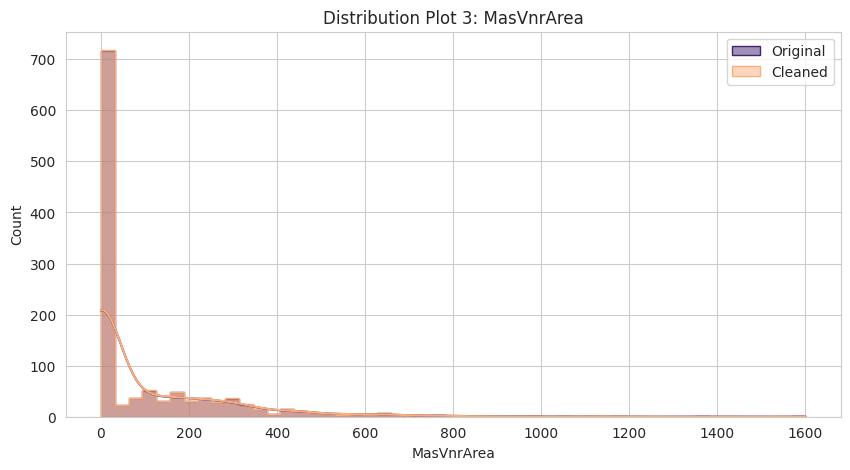

In [35]:
var = ['2ndFlrSF' , 'GarageYrBlt', 'MasVnrArea']
imputer = RandomSampleImputer(variables=var)
df_method = imputer.fit_transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=var)

**Analysis**

- For ```MassVnrArea```and ```SecondFlrSF```, both random sample and mean imputation give more or less same results. We will consider random sample distribution as final choice considering skewness of dataset.

- For ```GarageYrBlt```the values are more concentrated around 1975 for median imputation. 

-  When we are randomnly imputing values, it is possible that some rows where GarageYrBlt < YearBuilt. Means, garage was built before Original Construction date. If that is the case, we are introducing "Data Integrity issue". This needs to be avoided.



In [39]:

filtered_df = TrainSet.query('GarageYrBlt < YearBuilt')[['GarageYrBlt', 'YearBuilt']]
filtered_df

,GarageYrBlt,YearBuilt
1418,1962.0,1963
1414,1922.0,1923
1103,1954.0,1959
1376,1925.0,1930
736,1949.0,1950
93,1900.0,1910
324,1961.0,1967
600,2003.0,2005


**As you can see from the code above, introducing random or mean imputation leads to data integrity issue !!!**


One approach to deal with that is to "assume" that for missing values GarageYrBlt is equal to YearBuilt. There is about 5-6% of the total dataset is missing and we can fill the gap with this assumption.

However, it is risky to assume this without any underlying argument, just for the sake for analysis. We must have discussion about it with data provider and team. Additionally, we might be able to assume it for this dataset, but what about new upcoming data ? 

Sometimes, missing data is a pattern that should not be neglected.

The variable has strong correlation with other two variables from dataset, and hopefully they will be able to catch some of its traits.

Since it is part of larger discussion, for now it is best to drop this column and exclude it for further analysis (i.e. feature engineer, ML training) considering the scope of project.

**Mean Imputation**


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr'] 




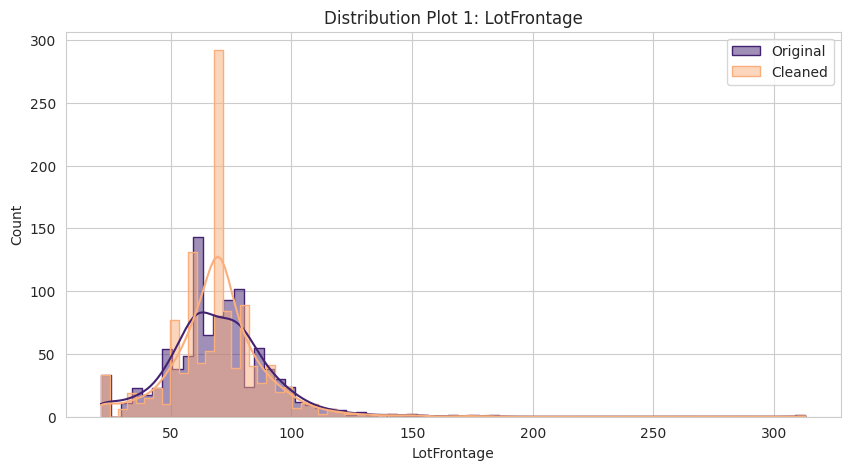

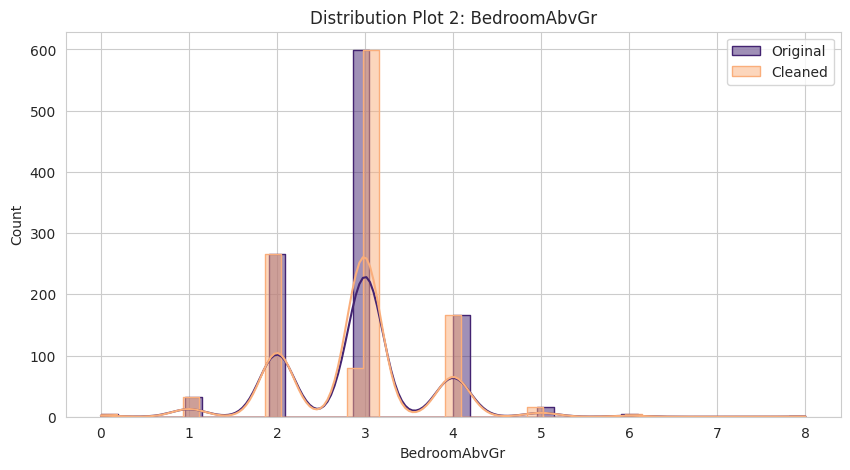

In [30]:
var = ['LotFrontage' , 'BedroomAbvGr']
imputer = MeanMedianImputer(imputation_method='mean', variables=var)
df_method = imputer.fit_transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=var)

**Analysis**

- For ```LotFrontage```Kurtosis increases post imputation. Let's try random sample distribution.



* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage'] 




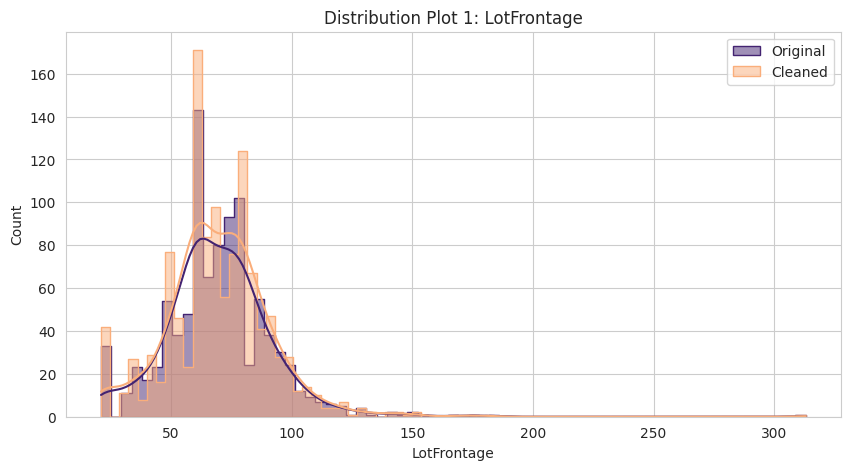

In [40]:
var = ['LotFrontage']
imputer = RandomSampleImputer(variables=var)
df_method = imputer.fit_transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=var)

The random sample method reduces kurtosis, so it will be the final choice.

Let's have a look at unique values from train set post imputation for ```BedroomAbvGr```

In [42]:
unique_val=TrainSet['BedroomAbvGr'].unique()
unique_val_list=list(unique_val)
unique_val_list

[nan, 2.0, 3.0, 4.0, 1.0, 5.0, 0.0, 6.0, 8.0]

It looks like there are no float values, which would have been the problem if existed (because we cannot have, for ex. 3.5 bedrooms). The distribution looks acceptable. So, mean imputation is our final choice.

## Summary and Pipeline Creation

- Drop variables ['EnclosedPorch', 'WoodDeckSF','GarageYrBlt']
- Categorical imputation for ['GarageFinish']
- Random sample imputation for ['BsmtFinType1','2ndFlrSF','MasVnrArea','LotFrontage']
- Mean imputation for ['BedroomAbvGr']

In [48]:
from sklearn.pipeline import Pipeline

TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

dataCleaning_pipeline = Pipeline([
    ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'GarageYrBlt', 'WoodDeckSF']) ),
    ( 'categorical',  CategoricalImputer(imputation_method='missing',
                                     fill_value='None',
                                     variables=['GarageFinish']) ),
    ( 'random_sample',  RandomSampleImputer(
                                     variables=['LotFrontage' ,
                                     'BsmtFinType1','2ndFlrSF','MasVnrArea']) ),
    ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['BedroomAbvGr']) ),
])

Let's apply pipeline to train and test set.

In [49]:
TrainSet, TestSet = dataCleaning_pipeline.fit_transform(TrainSet) , dataCleaning_pipeline.fit_transform(TestSet)

In [50]:
df = dataCleaning_pipeline.fit_transform(df)

Let's evaluate if there are any missing data

In [52]:
def EvaluateMissingData(df):
    """
    Evaluate missing data in each column and present it in precentage of dataset
    Args:
        df (_type_): pd.dataframe

    Returns:
        _type_: pd.dataframe
    """
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100 , 2)
    df_missing_data = (pd.DataFrame(
                            data= {"RowsWithMissingData": missing_data_absolute,
                                    "PercentageOfDataset": missing_data_percentage,
                                    "DataType":df.dtypes}
                                    )
                        .sort_values(by=['PercentageOfDataset'],ascending=False)
                        .query("PercentageOfDataset > 0")
                        )

    return df_missing_data

df_missing_data = EvaluateMissingData(df)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


## Push files to Repo

In [ ]:
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)